In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from importlib import reload
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import get_topic_clusters, create_embeddings, load_or_create_measurements_df, load_and_process_movielens, collect_parameters, load_measurements
from src.scoring_functions import cosine_sim, entropy, content_fairness
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, TopicInteractionMeasurement, MeanNumberOfTopics

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

In [2]:
def plot_histograms(model, measurements_df):
    # for every 10 timesteps plot line in different color
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))

    for i in range(10, timesteps+10, 10):
        ax[0].plot(np.arange(model.num_items), sorted(measurements_df['interaction_histogram'][i]), label=f't={i}')
        ax[1].plot(np.arange(model.num_items), sorted(measurements_df['topic_interaction_histogram'][i]), label=f't={i}')

    ax[0].set_title('Interaction Histogram')
    ax[0].set_xlabel('Items')
    ax[0].set_ylabel('# Interactions')
    ax[0].legend()
    # ax[1].set_title('Topic Interaction Similarity')
    # ax[1].set_xlabel('Topics')
    # ax[1].set_ylabel('# Interactions')
    # ax[1].legend()

In [3]:
def plot_measurements(dfs, parameters_df):

    fig, ax = plt.subplots(2, 3, figsize=(15, 15))
    fig.tight_layout(pad=5.0)

    legend_lines, legend_names = [], []
    for i, df in enumerate(dfs):
        ts = df['timesteps']
        name = parameters_df.loc[i, 'model_name']
        if not np.isnan(parameters_df.loc[i, 'Lambda']):
             name += f" (Lambda: {parameters_df.loc[i, 'Lambda']})" 
        legend_names.append(name)
        ax[0,0].plot(ts, df['mse'], label=name)
        ax[0,1].plot(ts, df['rec_similarity'], label=name)
        ax[0,2].plot(ts, df['interaction_similarity'], label=name)
        ax[1,0].plot(ts, df['serendipity_metric'], label=name)
        ax[1,1].plot(ts, df['novelty_metric'], label=name)
        line, = ax[1,2].plot(ts, df['diversity_metric'], label=name)
        legend_lines.append(line)

    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')

    ax[0, 0].set_title('Mean Squared Error')
    ax[0, 0].set_ylabel('MSE')
    ax[0, 0].set_yscale('log')
    
    ax[0, 1].set_title('Recommendation similarity')
    ax[0, 1].set_ylabel('Similarity')
    
    ax[0, 2].set_title('Interaction Similarity')
    ax[0, 2].set_ylabel('Jaccard Similarity')
    
    ax[1, 0].set_title('Serendipity')
    ax[1, 0].set_ylabel('Serendipity')
    
    ax[1, 1].set_title('Novelty')
    ax[1, 1].set_ylabel('Novelty')

    ax[1, 2].set_title('Diversity')
    ax[1, 2].set_ylabel('Diversity')
    
    fig.legend(legend_lines, legend_names, loc='upper center', fontsize=14, frameon=False, ncol=5, bbox_to_anchor=(.5, 1.05))

In [4]:
def collect_parameters(file, columns):   
    file_name = file[:-4]
    params = file_name.split('_')
    params_start_id = params.index('measurements')
    row = {}
    row['model_name'] = '_'.join(params[:params_start_id])
    for col in columns:
        for param in params:
            if param.endswith(col):
                value = param[:param.find(col)]
                row[col] = value
    return row


def load_measurements(path, columns):
    dfs = []
    data = []
    
    for file in os.listdir(path):
        if file.endswith('.csv'):
            row = collect_parameters(file, columns)
            data.append(row)
            df = pd.read_csv(path + '/' + file)
            dfs.append(df)
    
    parameters_df = pd.DataFrame().append(data)
    for col in numeric_cols:
        parameters_df[col] = pd.to_numeric(parameters_df[col])
    return dfs, parameters_df

# Analysis

In [6]:
numeric_cols = ['trainTimesteps', 'runTimesteps', 'nAttrs', 'nClusters', 'Drift', 'AttentionExp', 'Lambda']
columns = ['model_name'] + numeric_cols + ['PairAll']
dfs, parameters_df = load_measurements('artefacts/measurements', columns)

In [12]:
# filter plots by parameters
parameters_df_filtered = parameters_df[
    (
        (parameters_df['model_name'] == 'cosine_sim') 
        | (parameters_df['model_name'] == 'myopic')
        | (parameters_df['model_name'] == 'content_fairness')
        | (parameters_df['model_name'] == 'myopic_prob')
        | (parameters_df['model_name'] == 'entropy')
    )  
    & (parameters_df['trainTimesteps'] == 10)
    & (parameters_df['runTimesteps'] == 100)
    & (parameters_df['AttentionExp'] < 0)
    # & (parameters_df['Drift'] == 0.2)
    # & (parameters_df['Lambda'].isin([0.1, 0.5, 0.7, 1, np.nan]))
]

indexes = parameters_df_filtered.index.values
parameters_df_filtered = parameters_df_filtered.reset_index().drop(columns=['index'])

dfs_filtered = [dfs[x] for x in indexes]

Number of Attributes:  [20]
Number of Clusters:  [50]
Training Timesteps:  [10]
Running Timesteps:  [100]
Lambda:  [0.01 0.1   nan]


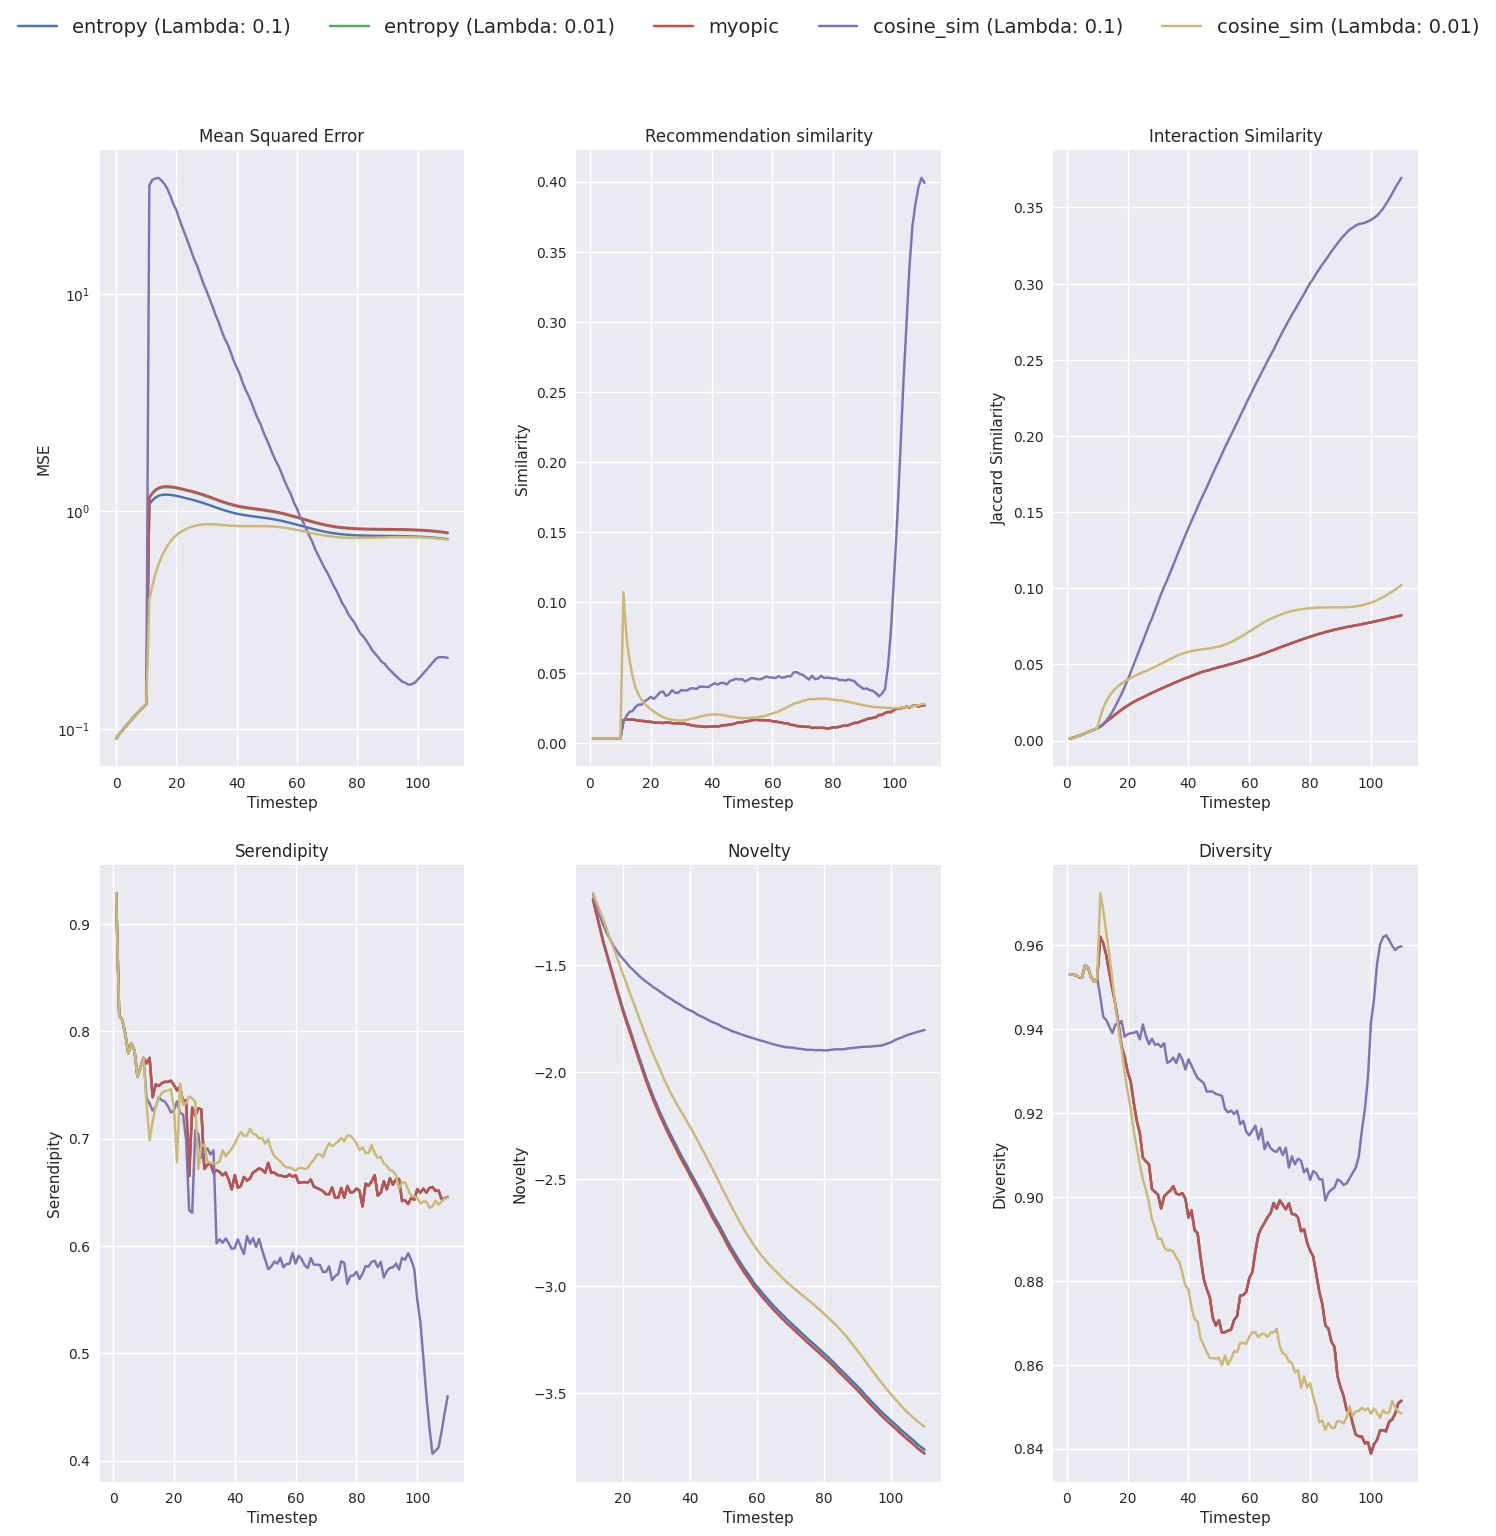

In [13]:
plot_measurements(dfs_filtered, parameters_df_filtered)

print("Number of Attributes: ", np.unique(parameters_df_filtered['nAttrs']))
print("Number of Clusters: ", np.unique(parameters_df_filtered['nClusters']))
print("Training Timesteps: ", np.unique(parameters_df_filtered['trainTimesteps']))
print("Running Timesteps: ", np.unique(parameters_df_filtered['runTimesteps']))
print("Lambda: ", np.unique(parameters_df_filtered['Lambda']))

In [ ]:
plot_histograms(dfs_filtered

In [14]:
display(parameters_df_filtered.sort_values('model_name'))

,model_name,trainTimesteps,runTimesteps,nAttrs,nClusters,Drift,AttentionExp,PairAll,Lambda
3,cosine_sim,10,100,20,50,0.05,-0.8,False,0.10
4,cosine_sim,10,100,20,50,0.05,-0.8,False,0.01
0,entropy,10,100,20,50,0.05,-0.8,False,0.10
1,entropy,10,100,20,50,0.05,-0.8,False,0.01
2,myopic,10,100,20,50,0.50,-0.8,False,NaN


In [15]:
serendipities = []
summary_df = pd.DataFrame()
                          
for df in dfs:
    row = df[df['state']=='run'].groupby('model').agg(
        MSE=('mse', 'last'),
        Diversity=('diversity_metric', 'mean'),
        Novelty=('novelty_metric', 'mean'),
        Serendipity=('serendipity_metric', 'mean'),
        Timesteps=('timesteps', 'max'))
    summary_df = summary_df.append(row)

In [16]:
summary_df

,MSE,Diversity,Novelty,Serendipity,Timesteps
model,,,,,
myopic,1.332788,0.897133,-1.782916,0.291426,30
entropy,0.743781,0.885929,-2.830626,0.673398,110
entropy,0.792342,0.885937,-2.845808,0.673449,110
myopic,0.797954,0.885938,-2.847463,0.673448,110
myopic,1.320253,0.923896,-2.730250,0.056323,110
cosine_sim,9.971489,0.881374,-1.726498,0.198458,60
cosine_sim,1.134914,0.843824,-2.099240,0.111558,110
entropy,1.118613,0.896929,-2.700369,0.058805,110
cosine_sim,1.636924,0.968053,-1.771460,0.426152,110
